# SegSoup library tutorial

In this notebook, we present a step-by-step tutorial on how to use SegSoup to build semantic segmentation model soups.

We begin by importing the required libraries. While these dependencies are not strictly necessary to use SegSoup itself, they are needed to construct the example dataset, load pretrained models, and reproduce the experiments shown in this notebook.

In [1]:
%pip install pytorch-lightning==2.5.1

In [2]:
%pip install segmentation-models-pytorch

In [3]:
from typing import Optional

import os
import torch
import cv2
import numpy as np
import re
import time
import warnings

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as A
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torch.optim import lr_scheduler
import pandas as pd
from tqdm import tqdm
from PIL import Image

from torchvision import models, transforms

import urllib.request
import zipfile

In [27]:
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

## Resources download ⬇️📁

For this demo, we will use the public **BUSI Dataset**, available in [Kaggle](https://www.kaggle.com/datasets/sabahesaraki/breast-ultrasound-images-dataset).

The dataset can be downloaded already partitioned using a hold-out split by running the cell below.

The checkpoints used to build the segmentation soup were trained using this same split and dataset. They correspond to an FPN model trained for 50 epochs, with checkpoints saved every 10 epochs.

In [4]:
url = "https://github.com/joortif/SegSoup/releases/download/v0.1.0/busi-holdout-soup.zip"
output = "busi_dataset_split"

print("Downloading dataset...")
urllib.request.urlretrieve(url, output)

with zipfile.ZipFile(output, "r") as zip_ref:
    zip_ref.extractall()

In [5]:
url = "https://github.com/joortif/SegSoup/releases/download/v0.1.0/models.zip"
output = "checkpoints"

print("Downloading checkpoints...")
urllib.request.urlretrieve(url, output)

with zipfile.ZipFile(output, "r") as zip_ref:
    zip_ref.extractall()

## Installation 💿

This library is installed via pip:

In [6]:
%pip install segsoup

## Dataset 📁

The cell below defines a simple Dataset class that can be used to load the images and masks from the BUSI dataset.

The applied preprocessing consists solely of resizing all images and masks to a fixed resolution of 512×512, ensuring consistent input dimensions for the model.

In [7]:
VALID_EXTENSIONS: tuple = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

def get_validation_augmentation(resize_height = 512, resize_width=512, background=None):
    if background == None:
        background = 0

    test_transform = [
       A.Resize(height=resize_height, width=resize_width),
       A.PadIfNeeded(min_height=None, min_width=None, pad_height_divisor=32, pad_width_divisor=32, fill=background, fill_mask=background)
    ]

    augment = A.Compose(test_transform)
    augment.background = background
    return augment

class Dataset(BaseDataset):

    def __init__(self, classes, images_dir=None, masks_dir=None, image_paths=None, mask_paths=None, augmentation=None, background=None, binary=True):

        self.augmentation = augmentation
        self.classes = classes
        self.binary = binary
        self.background_class = background

        if image_paths is not None and mask_paths is not None:
            assert len(image_paths) == len(mask_paths)
            self.image_paths = image_paths
            self.mask_paths = mask_paths
            self.mode = "paths"
            self.ids = [os.path.basename(p) for p in image_paths]
        else:
            self.mode = "dirs"
            self.image_paths = []
            self.mask_paths = []
            self.ids = []

            for fname in os.listdir(images_dir):
                if fname.lower().endswith(VALID_EXTENSIONS):
                    img_path = os.path.join(images_dir, fname)
                    mask_name = os.path.splitext(fname)[0] + ".png"
                    mask_path = os.path.join(masks_dir, mask_name)

                    if os.path.exists(mask_path):
                        self.image_paths.append(img_path)
                        self.mask_paths.append(mask_path)
                        self.ids.append(fname)

        self.class_values = [self.classes.index(cls.lower()) for cls in classes]

        # Create a remapping dictionary: class value in dataset -> new index (0, 1, 2, ...)
        # Background will always be 255, other classes will be remapped starting from 1.

        if self.binary:
            self.class_map = {v: 0 if v == self.background_class else 1 for v in self.class_values}
        else:
            self.class_map = {self.background_class: 255} if self.background_class is not None else {}
            self.class_map.update({v: i for i, v in enumerate(self.class_values) if v != self.background_class})

        self.augmentation = augmentation

    def __getitem__(self, i):

        image = cv2.imread(self.image_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[i], 0)

        # Read the image
        image = cv2.imread(self.image_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Read the mask in grayscale mode
        mask = cv2.imread(self.mask_paths[i], 0)

        # Create a blank mask to remap the class values
        if self.binary:
            mask_remap = np.where(mask == 0, 0, 1).astype(np.uint8)
        else:
            mask_remap = np.full_like(mask, 255 if self.background_class is not None else 0, dtype=np.uint8)
            for class_value, new_value in self.class_map.items():
                mask_remap[mask == class_value] = new_value

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask_remap)
            image, mask_remap = sample["image"], sample["mask"]

        image = image.transpose(2, 0, 1)

        return image, mask_remap

    def __len__(self):
        return len(self.ids)

    def get_class_map(self):
        return self.class_map

In [8]:
classes = ["background", "melanoma"]
batch_size = 8
num_workers= 4

x_val_dir = r"busi-holdout-soup/val/images"
y_val_dir = r"busi-holdout-soup/val/labels"

x_test_dir = r"busi-holdout-soup/test/images"
y_test_dir = r"busi-holdout-soup/test/labels"

valid_dataset = Dataset(
            images_dir =x_val_dir,
            masks_dir =y_val_dir,
            classes=classes,
            augmentation=get_validation_augmentation(512,512,0),
        )

test_dataset = Dataset(
            images_dir =x_test_dir,
            masks_dir =y_test_dir,
            classes=classes,
            augmentation=get_validation_augmentation(512,512,0),
        )

valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Metrics 📊

We define some metrics that evaluate the performance of segmentation models.

This code is slightly adapted from the library [Segmentation Models Pytorch (SMP)](https://github.com/qubvel-org/segmentation_models.pytorch).

In [9]:
def accuracy(tp, fp, fn, tn):
    return (tp + tn) / (tp + fp + fn + tn)

def iou_score(tp, fp, fn, tn):
    return tp / (tp + fp + fn)

def dice_score(tp, fp, fn, tn):
    return (2 * tp) / (2 * tp + fp + fn)

def precision(tp, fp, fn, tn):
    return tp / (tp + fp)

def recall(tp, fp, fn, tn):
    return tp / (tp + fn)

def f1_score(tp, fp, fn, tn, beta=1):
    beta_tp = (1 + beta**2) * tp
    beta_fn = (beta**2) * fn
    score = beta_tp / (beta_tp + beta_fn + fp)
    return score

def _handle_zero_division(x, zero_division):
    nans = torch.isnan(x)
    if torch.any(nans) and zero_division == "warn":
        warnings.warn("Zero division in metric calculation!")
    elif zero_division == "ignore":
        return x[~nans]

    value = zero_division if zero_division != "warn" else 0
    value = torch.tensor(value, dtype=x.dtype).to(x.device)
    x = torch.where(nans, value, x)
    return x

def custom_metric(tp, fp, fn, tn, metric_fn, reduction="micro", zero_division="warn"):
    if reduction == "micro":
        tp = tp.sum()
        fp = fp.sum()
        fn = fn.sum()
        tn = tn.sum()
        score = metric_fn(tp, fp, fn, tn)

    elif reduction == "micro-imagewise":
        tp = tp.sum(1)
        fp = fp.sum(1)
        fn = fn.sum(1)
        tn = tn.sum(1)
        score = metric_fn(tp, fp, fn, tn)
        score = _handle_zero_division(score, zero_division)
        score = score.mean()

    elif reduction == "none" or reduction is None:
        score = metric_fn(tp, fp, fn, tn)
        score = _handle_zero_division(score, zero_division)

    return score

metric_functions = {
    "accuracy": accuracy,
    "iou": iou_score,
    "dice": dice_score,
    "precision": precision,
    "recall": recall,
    "f1": f1_score,
}

def compute_metrics(results, metrics, classes, stage="train"):
    tp = torch.cat([x["tp"] for x in results])
    fp = torch.cat([x["fp"] for x in results])
    fn = torch.cat([x["fn"] for x in results])
    tn = torch.cat([x["tn"] for x in results])

    results = {}

    for metric in metrics:
        metric_fn = metric_functions[metric]

        score_global = custom_metric(tp, fp, fn, tn, metric_fn, reduction="micro")
        results[f"{metric}_{stage}"] = score_global.item() if torch.is_tensor(score_global) else score_global

        score_none = custom_metric(tp, fp, fn, tn, metric_fn, reduction="none")
        score_per_class = score_none.mean(dim=0)

        if len(classes) == 2:
            class_name = [c for c in classes if c != "background"][0]
            results[f"{metric}_{stage}_class_{class_name}"] = score_per_class.item()
        else:
            for class_idx, class_score in enumerate(score_per_class):
                class_name = classes[class_idx]
                results[f"{metric}_{stage}_class_{class_name}"] = class_score.item()

    return results

## Models 🤖

Here we define a wrapper class for SMP models, which will be used to load the checkpoints.

Users can, of course, use any other library (or custom implementations) to load their state dicts and construct model soups.

In [10]:
class SemanticSegmentationModel:

    def __init__(self, classes: np.ndarray, epochs:int, imgsz:int, metrics: np.ndarray,  model_name:str, model_size:str, output_path:str):

        self.classes = classes
        self.out_classes = len([cls for cls in self.classes if cls.lower() !="background"])
        self.epochs = epochs
        self.imgsz = imgsz
        self.metrics = metrics
        self.model_name = model_name
        self.model_size = model_size
        self.output_path = output_path

        self.lr = 2e-4

    def save_model(self, output_dir, weights_only=True):
        if not os.path.exists(output_dir):
            os.makedirs(output_dir, exist_ok=True)

        model_save_name = f"{self.model_name}-{self.model_size}-ep{self.epochs}.pt"
        output_path = os.path.join(output_dir,model_save_name)

        if weights_only:
            torch.save(self.model.state_dict(), output_path)
            # print(f"Model weights saved in {output_path}")
        else:
            torch.save(self.model, output_path)
            # print(f"Complete model saved in {output_dir}")

        return output_path

    def show_metrics(self, metrics, stage):

        print(f"{stage} metrics:\n")

        general_metrics = {k: v for k, v in metrics.items() if '_class_' not in k}

        print(f"{'Metric':<20} {'Value':>8}")
        print("-" * 30)
        for metric, value in general_metrics.items():
            print(f"{metric:<20} {value:>8.4f}")

        print("\nMetrics by Class:\n")

        class_pattern = re.compile(r'(.+)_class_(.+)')

        class_metrics = {}

        for key, value in metrics.items():
            match = class_pattern.match(key)
            if match:
                metric_name = match.group(1)
                class_idx = match.group(2)
                class_metrics.setdefault(metric_name, {})[class_idx] = value

        all_classes = sorted(set(idx for metric_dict in class_metrics.values() for idx in metric_dict))

        for metric_name, class_dict in class_metrics.items():
            print(f"{metric_name.replace('_', ' ').title()}:")
            print("-" * 30)
            for c in all_classes:
                val = class_dict.get(c, None)
                if val is not None:
                    print(f"Class {c:<2} : {val:>8.4f}")
                else:
                    print(f"Class {c:<2} : {'N/A':>8}")
            print()

    def run_training():
        raise NotImplementedError("Subclasses must implement this method")

    def save_metrics():
        raise NotImplementedError("Subclasses must implement this method")

In [26]:
class Model(pl.LightningModule, SemanticSegmentationModel):
    def __init__(self, in_channels: int , classes: int, metrics: np.ndarray, imgsz:int, epochs:int, t_max: Optional[int], output_path:str,
                 model_name: str="fpn", encoder_name: str="resnet34", **kwargs):

        super().__init__()

        SemanticSegmentationModel.__init__(self, classes=classes, epochs=epochs, imgsz=imgsz, metrics=metrics,
                                           model_name=model_name, model_size=encoder_name, output_path=output_path)
        self.model_name = model_name.replace("-", "")
        self.in_channels = in_channels

        self.model = smp.create_model(
            arch=self.model_name,
            encoder_name=self.model_size,
            in_channels=self.in_channels,
            classes=self.out_classes,
            activation=None,
            **kwargs,
        )

        self.t_max = t_max

        # Preprocessing parameters for image normalization
        params = smp.encoders.get_preprocessing_params(self.model_size)
        self.number_of_classes = self.out_classes
        self.binary = self.out_classes == 1
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))
        self.ignore_index = None

        if self.binary:
            self.loss_mode = smp.losses.BINARY_MODE
        else:
            self.loss_mode = smp.losses.MULTICLASS_MODE
            self.ignore_index = 255

        self.loss_fn = smp.losses.DiceLoss(self.loss_mode, from_logits=True, ignore_index=self.ignore_index)

        # Step metrics tracking
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # Normalize image
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def validate_segmentation_batch(self, image, mask):

        assert image.ndim == 4, f"Expected image ndim=4, got {image.ndim}" # [batch_size, channels, H, W]
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0, f"Image dimensions must be divisible by 32, got {h}x{w}"

        if self.binary:
            if mask.ndim == 3:
                mask = mask.unsqueeze(1)
            assert mask.ndim == 4, f"Expected binary mask ndim=4, got {mask.ndim}"
            assert mask.max() <= 1.0 and mask.min() >= 0.0, "Binary mask values must be in range [0, 1]"
        else:
            assert mask.ndim == 3, f"Expected multiclass mask ndim=3, got {mask.ndim}"
            mask = mask.long()

        return image, mask

    def shared_step(self, batch, stage):
        image, mask = batch

        image, mask = self.validate_segmentation_batch(image, mask)

        logits_mask = self.forward(image)

        logits_mask = logits_mask.contiguous()

        loss = self.loss_fn(logits_mask, mask)

        if self.binary:
            prob_mask = logits_mask.sigmoid()
            pred_mask = (prob_mask > 0.5).float()

        else:
            prob_mask = logits_mask.softmax(dim=1)
            pred_mask = prob_mask.argmax(dim=1)

        if self.binary:
            metric_args = {"mode": "binary"}
        else:
            metric_args = {"mode": "multiclass", "num_classes": self.number_of_classes, "ignore_index": self.ignore_index}

        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), **metric_args)

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        results = compute_metrics(outputs, self.metrics, self.classes, stage)
        self.log_dict(results, prog_bar=True)

    def training_step(self, batch):
        train_loss_info = self.shared_step(batch, "train")
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()

    def validation_step(self, batch):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()

    def test_step(self, batch):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.t_max, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

    def validate(self, valid_loader):
        trainer = pl.Trainer(logger=False, enable_checkpointing=False, devices=1)
        valid_metrics = trainer.validate(self, dataloaders=valid_loader, verbose=False)
        return valid_metrics

    def test(self, test_loader):
        trainer = pl.Trainer(logger=False, enable_checkpointing=False, devices=1)
        test_metrics = trainer.test(self, dataloaders=test_loader, verbose=False)
        return test_metrics

    def load_weights(self, weights):
        self.model.load_state_dict(weights)

## Baseline 🏁

Firstly, we evaluate all checkpoints on the test split taking the Dice coefficient as the main metric.

The models are loaded using the ``load_weights`` function, which takes the directory containing the saved checkpoints as input.

In [34]:
from segsoup import load_weights

state_dicts = load_weights("models", verbose=True)

Loaded models/FPN_checkpoint_epoch_10.pt
Loaded models/FPN_checkpoint_epoch_20.pt
Loaded models/FPN_checkpoint_epoch_30.pt
Loaded models/FPN_checkpoint_epoch_40.pt
Loaded models/FPN_checkpoint_epoch_50.pt


In [35]:
test_results = []
test_metrics_full = []

for epoch, sd in zip(range(10, 51, 10), state_dicts):
    model = Model(model_name="fpn", encoder_name="resnet34", in_channels=3, out_classes=1, metrics=["dice"],
                classes=classes, output_path=None, ignore_index=None, t_max=None, epochs=0, imgsz=512)


    model.load_weights(sd)

    test_metrics = model.test(test_loader)

    dice_test = test_metrics[0]["dice_test"]

    print(f"Test Dice Score for checkpoint (epoch {epoch}): {dice_test: .4f}")

    test_results.append(dice_test)

Testing: |          | 0/? [00:00<?, ?it/s]

Test Dice Score for checkpoint (epoch 10):  0.7076


Testing: |          | 0/? [00:00<?, ?it/s]

Test Dice Score for checkpoint (epoch 20):  0.7456


Testing: |          | 0/? [00:00<?, ?it/s]

Test Dice Score for checkpoint (epoch 30):  0.7594


Testing: |          | 0/? [00:00<?, ?it/s]

Test Dice Score for checkpoint (epoch 40):  0.7555


Testing: |          | 0/? [00:00<?, ?it/s]

Test Dice Score for checkpoint (epoch 50):  0.7577


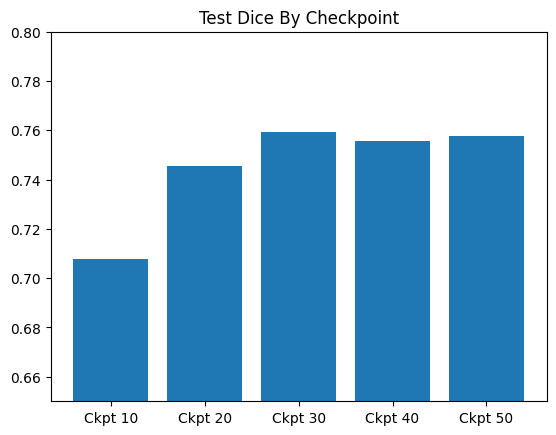

In [36]:
names = [f'Ckpt {epoch}' for epoch in range(10, 51, 10)]
plt.bar(names, test_results)
plt.ylim([0.65, 0.80])
plt.title("Test Dice By Checkpoint")
plt.show()

## Segmentation soups 🍲

### Uniform soup 🍜

The uniform soup is created by simply averaging the state dicts.

In [37]:
from segsoup import get_segmentation_soup, Strategy

uniform_soup, _, _= get_segmentation_soup(
    state_dicts,
    strategy=Strategy.UNIFORM
)

In [38]:
model = Model(model_name="fpn", encoder_name="resnet34", in_channels=3, imgsz=512,
                 classes=classes, metrics=["dice"], t_max=None, output_path=None, epochs=0)
model.load_weights(uniform_soup)
test_metrics = model.test(test_loader)

dice_test = test_metrics[0]["dice_test"]

print(f"Test Dice Score for uniform soup: {dice_test: .4f}")

Testing: |          | 0/? [00:00<?, ?it/s]

Test Dice Score for uniform soup:  0.7784


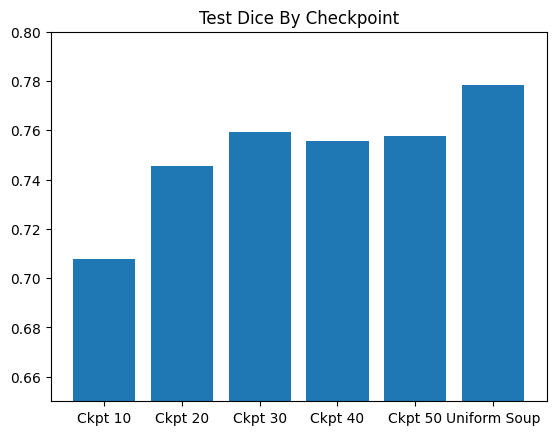

In [39]:
test_results.append(dice_test)
names.append("Uniform Soup")
plt.bar(names, test_results)
plt.ylim([0.65, 0.80])
plt.title("Test Dice By Checkpoint")
plt.show()

### Weighted soup 💪

For the weighted soup, the user can provide an array to specify the contribution of each state dict.

In this example, since the checkpoints come from the same training process, we assign higher weights to the later checkpoints, which have been trained longer.

In [40]:
weights = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float32)
weights /= weights.sum()

weighted_soup, _, _= get_segmentation_soup(
    state_dicts,
    weights=weights,
    strategy=Strategy.WEIGHTED
)

In [41]:
model = Model(model_name="fpn", encoder_name="resnet34", in_channels=3, imgsz=512,
                 classes=classes, metrics=["dice"], t_max=None, output_path=None, epochs=0)
model.load_weights(weighted_soup)
test_metrics = model.test(test_loader)

dice_test = test_metrics[0]["dice_test"]

print(f"Test Dice Score for weighted soup: {dice_test: .4f}")

Testing: |          | 0/? [00:00<?, ?it/s]

Test Dice Score for weighted soup:  0.7710


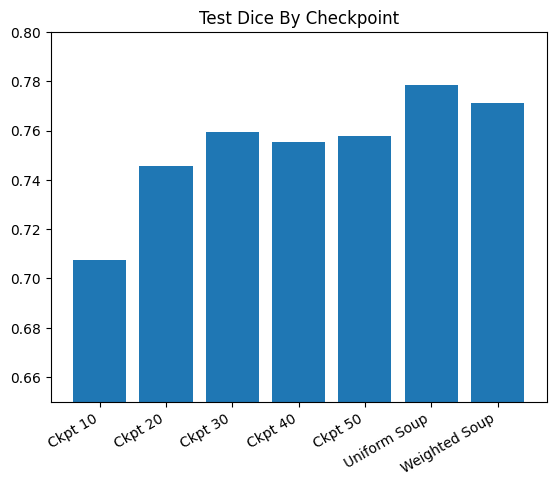

In [42]:
test_results.append(dice_test)
names.append("Weighted Soup")
plt.bar(names, test_results)
plt.ylim([0.65, 0.80])
plt.title("Test Dice By Checkpoint")
plt.xticks(rotation=30, ha='right')
plt.show()

### Greedy soup 🤑

In the greedy soup, models are added sequentially to the soup and only kept if the validation score of the resulting soup improves.

The user must define a function to evaluate the state dicts on a validation dataset. This function must accept a state dict as input and return a scalar value.

In [43]:
#In order to evaluate a model, it must be created/initialized.
#This process can vary depending the library or implementation used.
def validate_model(state_dict):
    model = Model(model_name="fpn", encoder_name="resnet34", in_channels=3, imgsz=512,
                 classes=classes, metrics=["dice"], t_max=None, output_path=None, epochs=0)
    model.load_weights(state_dict)
    metrics = model.validate(valid_loader)

    dice_valid = metrics[0]["dice_valid"]

    return dice_valid

greedy_soup, score, ckpts_selected= get_segmentation_soup(
    state_dicts,
    strategy=Strategy.GREEDY,
    evaluate_fn=validate_model,
    verbose=True
)

print(f"Selected checkpoints: {ckpts_selected}")
print(f"Validation score obtained with greedy soup: {score: .4f}")

Validation: |          | 0/? [00:00<?, ?it/s]

Individual model 0 -> score  0.7351


Validation: |          | 0/? [00:00<?, ?it/s]

Individual model 1 -> score  0.7953


Validation: |          | 0/? [00:00<?, ?it/s]

Individual model 2 -> score  0.7900


Validation: |          | 0/? [00:00<?, ?it/s]

Individual model 3 -> score  0.7933


Validation: |          | 0/? [00:00<?, ?it/s]

Individual model 4 -> score  0.8025
Order by individual score: [4, 1, 3, 2, 0]
Starting with model 4 (score= 0.8025)


Validation: |          | 0/? [00:00<?, ?it/s]

Trying to add 1 -> candidate score 0.8077840805053711
Accepted 1 -> new score  0.8078


Validation: |          | 0/? [00:00<?, ?it/s]

Trying to add 3 -> candidate score 0.8051369786262512
Rejected 3 (no improvement)


Validation: |          | 0/? [00:00<?, ?it/s]

Trying to add 2 -> candidate score 0.8040251731872559
Rejected 2 (no improvement)


Validation: |          | 0/? [00:00<?, ?it/s]

Trying to add 0 -> candidate score 0.8035923838615417
Rejected 0 (no improvement)
Selected checkpoints: [4, 1]
Validation score obtained with greedy soup:  0.8078


In [44]:
model = Model(model_name="fpn", encoder_name="resnet34", in_channels=3, imgsz=512,
                 classes=classes, metrics=["dice"], t_max=None, output_path=None, epochs=0)
model.load_weights(greedy_soup)
test_metrics = model.test(test_loader)

dice_test = test_metrics[0]["dice_test"]

print(f"Test Dice Score for greedy soup: {dice_test: .4f}")

Testing: |          | 0/? [00:00<?, ?it/s]

Test Dice Score for greedy soup:  0.7727


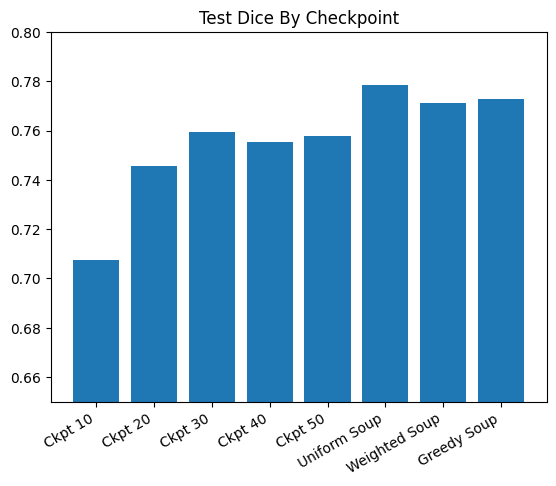

In [45]:
test_results.append(dice_test)
names.append("Greedy Soup")
plt.bar(names, test_results)
plt.ylim([0.65, 0.80])
plt.title("Test Dice By Checkpoint")
plt.xticks(rotation=30, ha='right')
plt.show()